In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/garipov/decomposed/")

In [3]:
import yaml
from yaml import Loader

logdir_i = logdir / "1647855291"

with open(logdir_i / 'config.yml') as yaml_file:
    config_i = yaml.load(yaml_file, Loader=Loader)
config_i

{'baseline_path': '/bigdata/cifar10/logs/garipov/baselines/1647358615/gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue/cnn_best.pth',
 'batch': 128,
 'data_dir': '/bigdata/cifar10',
 'data_workers': 8,
 'dataset': 'cifar10',
 'decompose_weights': True,
 'epochs': 10,
 'factorization': 'tucker',
 'gamma': 0,
 'hexsha': '6d9984789338f9cedaf622c602df6aab52f24e83',
 'layers': [6],
 'logdir': '/bigdata/cifar10/logs/garipov/decomposed',
 'lr': 0.0001,
 'model_name': 'gar',
 'momentum': 0.9,
 'optimizer': 'sgd',
 'rank': '0.9',
 'seed': 1647855291,
 't': 1647855291,
 'weight_decay': 0}

In [10]:
import torch

baseline_path = Path('/bigdata/cifar10/logs/garipov/baselines/1647358615/gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue')
# baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result

{'best_epoch': 38,
 'best_train_acc': 0.9749333333333333,
 'best_valid_acc': 0.9078,
 'best_valid_loss': 0.003568341651931405,
 'test_acc': 0.891,
 'test_loss': 0.004007616302371025,
 'n_param': 557642,
 'model_name': 'gar_18_dNone_128_sgd_l0.1_g0.1_w0.0_sTrue'}

In [3]:
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

In [4]:
import os
from pandas import DataFrame

from tddl.post_processing.path_utils import logdir_to_df

df = logdir_to_df(logdir)


In [5]:
g = df.groupby(['factorization','rank','layer']).first()
df2 = g.reset_index()

In [6]:
df_select = df2[
    (df2['factorization'] == 'tucker') &
    (df2['rank'] == 0.5)
]

In [7]:
df_select['layer']

60     2.0
61     4.0
62     6.0
63     8.0
64    10.0
Name: layer, dtype: float64

In [8]:
gar_layers = [0,2,4,6,8,10,11]

In [11]:
from tddl.factorizations import get_weights
from tddl.post_processing.differences import weight_difference
from tddl.plotting.kde import kde_diff
from tddl.plotting.bar import bar_diff

dfs = []
df_diffs = []
for index, row in df_select.iterrows():
    # print(index, row)

    weights_fact = get_weights(torch.load(row['model_fact']), gar_layers)
    weights_best = get_weights(torch.load(row['model_best']), gar_layers)
    weights_final = get_weights(torch.load(row['model_final']), gar_layers)

    layer = int(row['layer'])

    df = weight_difference(weights_fact, weights_final, gar_layers, layer)
    df_diff = df.explode(column='diff',ignore_index=True)

    dfs.append(df)
    df_diffs.append( df.explode(column='diff',ignore_index=True) )

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [12]:
logdir_model = logdir_i / "gar-lr-[6]-tucker-0.9-dTrue-iNone_bn_128_sgd_l0.0001_g0.0_sTrue" 

model_best = torch.load(logdir_model / "fact_model_best.pth")
model_final = torch.load(logdir_model / "fact_model_final.pth")
model_fact = torch.load(logdir_model / "model_after_fact.pth")

NameError: name 'logdir_i' is not defined

In [13]:
fact_layer = model_fact.conv4
fact_weight = fact_layer.weight
fact_weight.to_tensor()

NameError: name 'model_fact' is not defined

In [14]:
from tddl.factorizations import number_layers, listify_numbered_layers

numbered_layers = number_layers(baseline_model)
numbered_layers

NameError: name 'baseline_model' is not defined

In [15]:
# loop over layers to get list with the weights

from tddl.factorizations import number_layers, listify_numbered_layers

gar_layers = [0,2,4,6,8,10,11]

def get_weights(model, layer_nrs=[0,6,9,12,15,19,22,25,28,31,35,38,41,44,47,51,54,57,60,63,66]):
    numbered_layers = number_layers(model)
    listed_layers = listify_numbered_layers(numbered_layers=numbered_layers, layer_nrs=layer_nrs)
    return {nr:layer.weight for name,nr,layer in listed_layers}

weights_fact = get_weights(model_fact, [0,2,4,6,8,10,11])
weights_best = get_weights(model_best, [0,2,4,6,8,10,11])
weights_final = get_weights(model_final, [0,2,4,6,8,10,11])

NameError: name 'model_fact' is not defined

In [16]:
from tensorly import tensor_to_vec
from numpy.linalg import norm
from pandas import DataFrame


def weight_difference(weights_a, weights_b, layer_nrs, fact_nr):

    df = DataFrame(columns=['layer_nr', 'fact_nr', 'norm_2', 'norm_1', 'diff','relative_norm_2','relative_norm_1'])
    for nr in layer_nrs:
        with torch.no_grad():
            diff = (tensor_to_vec(weights_a[nr])-tensor_to_vec(weights_b[nr])).cpu().numpy()
        
            # norm on difference
            norm_2 = norm(diff)
            norm_1 = norm(diff, ord=1)

            relative_norm_2 = norm_2 / norm(tensor_to_vec(weights_a[nr]).cpu().numpy())
            relative_norm_1 = norm_1 / norm(tensor_to_vec(weights_a[nr]).cpu().numpy(), ord=1)

        df = df.append({
            'layer_nr':nr,
            'fact_nr':fact_nr,
            'norm_2':norm_2,
            'norm_1':norm_1,
            'diff': diff,
            'relative_norm_2': relative_norm_2,
            'relative_norm_1': relative_norm_1,
        }, ignore_index=True)

    return df

df = weight_difference(weights_fact, weights_best, gar_layers, config_i['layers'][0])
df_diff = df.explode(column='diff',ignore_index=True)

NameError: name 'weights_fact' is not defined

In [17]:
df

,baseline_path,batch,data-workers,data_dir,data_workers,dataset,decompose_weights,epochs,factorization,gamma,...,model_best,model_fact,model_final,model_name,momentum,optimizer,rank,seed,t,weight_decay
0,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,0.61,1.660602e+09,1.660602e+09,0.0
1,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tucker,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,gar,0.9,sgd,0.90,1.647854e+09,1.647854e+09,0.0
2,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tucker,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,gar,0.9,sgd,0.90,1.647857e+09,1.647857e+09,0.0
3,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,cp,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16477...,/bigdata/cifar10/logs/garipov/decomposed/16477...,/bigdata/cifar10/logs/garipov/decomposed/16477...,gar,0.9,sgd,0.75,1.647781e+09,1.647781e+09,0.0
4,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,1.22,1.660618e+09,1.660618e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,1.22,1.660612e+09,1.660612e+09,0.0
371,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,0.61,1.660606e+09,1.660606e+09,0.0
372,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tucker,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,gar,0.9,sgd,0.90,1.647859e+09,1.647859e+09,0.0
373,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,6,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16629...,/bigdata/cifar10/logs/garipov/decomposed/16629...,/bigdata/cifar10/logs/garipov/decomposed/16629...,gar,0.9,sgd,1.43,1.662991e+09,1.662991e+09,0.0


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_diff, row="layer_nr", hue="layer_nr", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "diff",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "diff", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "diff")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

NameError: name 'df_diff' is not defined

In [19]:
fig = sns.barplot(data=df, x="layer_nr", y="relative_norm_1")
fig.get_figure().savefig('../../plots/gar_c10_difference_relnorm1.pdf')

ValueError: Could not interpret input 'layer_nr'

In [20]:
fig = sns.barplot(data=df, x="layer_nr", y="norm_1")
fig.get_figure().savefig('../../plots/gar_c10_difference_norm1.pdf')

ValueError: Could not interpret input 'layer_nr'

In [21]:
df

,baseline_path,batch,data-workers,data_dir,data_workers,dataset,decompose_weights,epochs,factorization,gamma,...,model_best,model_fact,model_final,model_name,momentum,optimizer,rank,seed,t,weight_decay
0,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,0.61,1.660602e+09,1.660602e+09,0.0
1,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tucker,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,gar,0.9,sgd,0.90,1.647854e+09,1.647854e+09,0.0
2,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tucker,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,gar,0.9,sgd,0.90,1.647857e+09,1.647857e+09,0.0
3,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,cp,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16477...,/bigdata/cifar10/logs/garipov/decomposed/16477...,/bigdata/cifar10/logs/garipov/decomposed/16477...,gar,0.9,sgd,0.75,1.647781e+09,1.647781e+09,0.0
4,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,1.22,1.660618e+09,1.660618e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,1.22,1.660612e+09,1.660612e+09,0.0
371,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,4,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,/bigdata/cifar10/logs/garipov/decomposed/16606...,gar,0.9,sgd,0.61,1.660606e+09,1.660606e+09,0.0
372,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,NaN,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tucker,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,/bigdata/cifar10/logs/garipov/decomposed/16478...,gar,0.9,sgd,0.90,1.647859e+09,1.647859e+09,0.0
373,/bigdata/cifar10/logs/garipov/baselines/164735...,128.0,6,/bigdata/cifar10,8.0,cifar10,1.0,10.0,tt,0.0,...,/bigdata/cifar10/logs/garipov/decomposed/16629...,/bigdata/cifar10/logs/garipov/decomposed/16629...,/bigdata/cifar10/logs/garipov/decomposed/16629...,gar,0.9,sgd,1.43,1.662991e+09,1.662991e+09,0.0


In [22]:
df_ = pd.concat(dfs)
df_['log_rel_norm_1'] = np.log(df_["relative_norm_1"])

df_pivot = df_.pivot("fact_nr", "layer_nr", "relative_norm_1")
df_pivot_log = df_.pivot("fact_nr", "layer_nr", "log_rel_norm_1")

ValueError: No objects to concatenate

In [23]:
f = sns.heatmap(df_pivot)

NameError: name 'df_pivot' is not defined

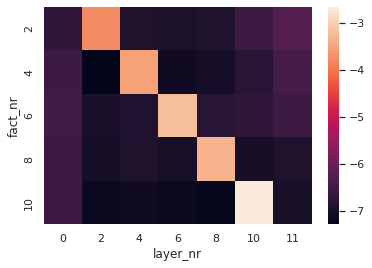

In [51]:
f = sns.heatmap(df_pivot_log)
f.get_figure().savefig('../../plots/gar_c10_difference_heat_contr_log_rel_norm1_final.pdf')